#Implementing InstaHide
In this notebook we implement the algorithm from the paper [InstaHide: Instance-hiding Schemes for Private Distributed Learning](https://arxiv.org/abs/2010.02772)

In [1]:
import os

if not os.path.isdir('/content/aml_project'):
  !git clone https://github.com/s295103/aml_project.git
  %cd /content/aml_project
else:
  if os.getcwd() != "/content/aml_project":
    %cd /content/aml_project/
  !git pull origin

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR100, Caltech101
from utils import cifar_processing, load_model
from architectures import ResNet, BasicBlock
from instahide import InstaHide
import matplotlib.pyplot as plt
import csv
import pickle

ROOT = "/content"
BATCH_SIZE = 128
NUM_CLASSES = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CH_MEAN = (0.485, 0.456, 0.406) # ImageNet's Mean
CH_STDDEV = (0.229, 0.224, 0.225) # ImageNet's Std Dev

/content/aml_project
Already up to date.


##Visualize InstaHide encryption

In [ ]:
# Get dataset
data = CIFAR100(ROOT, True, download=True)
n = len(data)

# Get a batch of images
sample_idxs = torch.randint(0, n, (BATCH_SIZE,))
imgs = []
labs = []
for i in sample_idxs:
    img, lab = data[i]
    imgs.append(img)
    labs.append(lab)

# Load label ids to names mapping
with open(ROOT + "/cifar-100-python/meta", "rb") as f:
    label_names = pickle.load(f)

# Transform
tr_imgs = torch.empty(BATCH_SIZE, 3, 32, 32)
transform_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CH_MEAN, CH_STDDEV)
])
# Apply transform
for i, im in enumerate(imgs):
    tr_imgs[i] = transform_imgs(im)

# Compute inverse normalization transform
# y = (x - mean) / stddev =>  x = 1/stddev * (y - (-mean/stddev))
inv_ch_mean = [-m/s for m, s in zip(CH_MEAN, CH_STDDEV)]
inv_ch_stddev = [1/s for s in CH_STDDEV]
transform_enc_imgs = transforms.Compose([
    transforms.Normalize(inv_ch_mean, inv_ch_stddev),
    transforms.ToPILImage(),
])

# Initialize multiple instances of InstaHide with different k
kmin=1
kmax=4
instahide = [InstaHide(k = k, device=DEVICE ) for k in range(kmin, kmax+1)]

# Encode images for different k
enc_imgs = []
for ih in instahide:
    enc_imgs.append(ih.encode(tr_imgs, NUM_CLASSES, torch.Tensor(labs))[0])

# Transpose so that each element contains all encodings of the same image
enc_imgs = [_ for _ in zip(*enc_imgs)]

# Sample images from batch
num_samples = 5
sampled_idxs = torch.randint(0, BATCH_SIZE, (num_samples,))
imgs_to_plot = []
labs_to_plot = []
enc_imgs_to_plot = []
for i in sampled_idxs:
    imgs_to_plot.append(imgs[i])
    labs_to_plot.append(labs[i])
    enc_imgs_to_plot.append(enc_imgs[i])

# Un-transform encrypted images
for i, imgs in enumerate(enc_imgs_to_plot):
    enc_imgs_to_plot[i] = [transform_enc_imgs(im) for im in imgs]

# Plot original and encrypted images
fig, axs = plt.subplots(num_samples, kmax+1)
for i in range(num_samples):
    for k in range(kmax+1):
        # Set column title
        if k == 0:
            axs[0, k].set_title("Original Image")
        else:
            axs[0, k].set_title("k = " + str(k))

        # Set tick labels and params
        axs[i, k].set_xticklabels([])
        axs[i, k].set_yticklabels([])
        axs[i, k].tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

        # Plot images
        if k == 0:
            axs[i, k].set_ylabel(label_names["fine_label_names"][labs_to_plot[i]])
            axs[i, k].imshow(imgs_to_plot[i])
        else:
            axs[i, k].imshow(enc_imgs_to_plot[i][k-1])

plt.tight_layout()
plt.savefig(ROOT + '/original_vs_instahide_encryption')

##Define the training routine

In [ ]:
# Hyperparameters
VAL_RATIO = 0.2
GROUPS = 2
NORM_LAYER = "gn"
LAYERS = [3, 3, 3]

# Make ResNet20
NET = ResNet(BasicBlock, LAYERS, num_classes=NUM_CLASSES, norm_layer=NORM_LAYER, groups=GROUPS)

# Training, validation and test set
TRAIN_SET, VAL_SET, TEST_SET = cifar_processing(
    cifar100=True,
    val_ratio=VAL_RATIO,
    root=ROOT
    )

# Training routine
def instahide_train_on_cifar(
    k:int,
    num_epochs:int,
    lr:float,
    momentum:float,
    weight_decay:float,
    file_path: str,
    public_dataset:Dataset=None,
    checkpoint_file:str=None,
    num_workers:int = 4
) -> tuple[float, float]:

    instahide = InstaHide(
                      k = k,
                      device=DEVICE,
                      c = 0.65, # Default value used in the paper
                      num_pred = 5,
                      num_workers = num_workers
                      )

    val_acc = instahide.training(
                            net = NET,
                            training_set = TRAIN_SET,
                            validation_set = VAL_SET,
                            num_classes = NUM_CLASSES,
                            num_epochs = num_epochs,
                            batch_size = BATCH_SIZE,
                            lr = lr,
                            momentum = momentum,
                            weight_decay = weight_decay,
                            path= file_path,
                            public_dataset = public_dataset,
                            resume_file = checkpoint_file,
                            val_freq=10,
                            )

    test_acc = instahide.inference(
                              net = NET,
                              test_set = TEST_SET,
                              num_classes = NUM_CLASSES,
                              batch_size = BATCH_SIZE,
                              model_path = file_path + "/best_model.pth",
                              encoding_data = TRAIN_SET
                              )

    return val_acc, test_acc

##Train with Inside InstaHide

In [ ]:
#Train for k values ranging from 1 to 4

if not os.path.isdir('inside'):
  !mkdir inside

k = [1, 2, 3, 4]
lr = [0.1, 0.1, 0.1, 0.1]
weight_decay = [1e-4, 1e-4, 1e-4, 1e-4]
momentum = [0.9, 0.9, 0.9, 0.9]
num_epochs = [250, 250, 250, 250]
num_workers = 8

inside_acc = {}
for i in range(3, 4):
#for i in range(4):
    dirname=os.getcwd() + "/inside/k_" + str(k[i])
    !mkdir $dirname
    _, test_acc = instahide_train_on_cifar(
                                      k = k[i],
                                      num_epochs = num_epochs[i],
                                      lr = lr[i],
                                      momentum = momentum[i],
                                      weight_decay = weight_decay[i],
                                      file_path = dirname,
                                      checkpoint_file=dirname + "/checkpoint.pth",
                                      num_workers = num_workers
                                      )
    inside_acc.update({k[i]:test_acc})
    with open("test_acc.csv", "a") as file:
      writer = csv.writer(file)
      writer.writerow([k[i], test_acc])


##Plot k vs accuracy

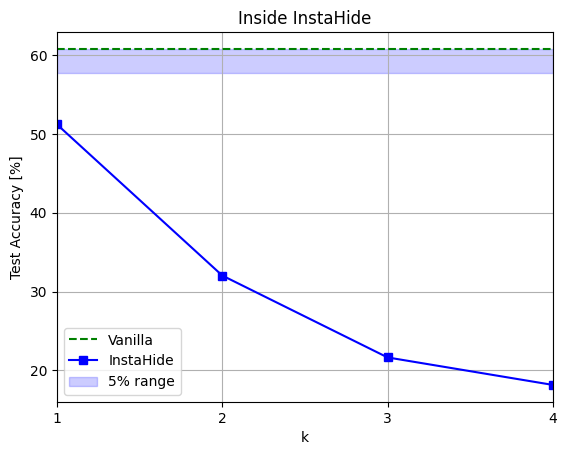

In [4]:
# Load accuracy data
try:
  inside_acc # Check if it exists
  if inside_acc is None or not bool(inside_acc):
    Exception()
except:
  with open("/content/inside/test_acc.csv", "r") as file:
    reader = csv.reader(file)
    inside_acc = {}
    for k, acc in reader:
        inside_acc.update({int(k):float(acc)})

# Load vanilla ResNet20 test accuracy
model = load_model(ROOT + "/aml_project/results/resnet20/resnet20gn_best_model.pth")
five_perc = 0.95*100*model["accuracy"]


plt.title("Inside InstaHide")
plt.ylabel("Test Accuracy [%]")
plt.xlabel("k")
kappas = list(inside_acc.keys())
top_acc = [100*model["accuracy"] for _ in range(len(inside_acc))]
accs = [100*a for a in list(inside_acc.values())]
plt.xlim(min(kappas), max(kappas))
plt.xticks(kappas)
plt.grid(True)
plt.plot(kappas, top_acc, "--g", label="Vanilla")
plt.plot(kappas, accs, "-sb", label="InstaHide")
plt.fill_between(kappas, top_acc, five_perc, color="b", alpha=0.2, label="5% range")
plt.legend()

plt.savefig(ROOT + "/inside_k_vs_accuracy")

##Train with Cross InstaHide

In [ ]:
# Prepare public dataset
public_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.repeat(3, 1, 1) if x.size() != (3, 32, 32) else x),
    transforms.Normalize(CH_MEAN, CH_STDDEV)
    ])

# We use Caltech101 as public dataset, since ImageNet it's too large to download
public_data = Caltech101(ROOT, transform=public_transforms, download=True)

# Make destination folder
if not os.path.isdir('cross'):
  !mkdir cross

dirname = os.getcwd() + "/cross"
k = 2
num_workers = 4 # Reduce it because we need two dataloaders

_, test_acc = instahide_train_on_cifar(
                                  k = k,
                                  lr = 0.1,
                                  num_epochs = 250,
                                  weight_decay = 1e-4,
                                  momentum = 0.9,
                                  file_path = dirname,
                                  public_dataset = public_data,
                                  checkpoint_file=dirname + "/checkpoint.pth",
                                  num_workers = num_workers
                                  )
print("Cross InstaHide")
print(f"\tTest accuracy for k = {k} : {100*test_acc:.1f}%")